Note: by cropping here we loose some data (temporally), but we use the dataframe for window processing and need NaN-free series

In [145]:
import require
import numpy as np
from tqdm import tqdm
from IPython.display import Markdown as md
get_data_for_country = require.single( "get_data_for_country" )
crop_to_valid_range = require.single( "crop_to_valid_range" )

dataframes = [ ]

for country in tqdm([ "Germany", "Switzerland", "Italy", "France", "Belgium", "United States" ]):

    df = get_data_for_country( country, verbose = False )
    df = crop_to_valid_range( df ).copy( ) 
    dataframes.append( df )

  0%|                                                                                                             | 0/6 [00:00<?, ?it/s]

 17%|████████████████▊                                                                                    | 1/6 [00:02<00:14,  2.93s/it]

 33%|█████████████████████████████████▋                                                                   | 2/6 [00:05<00:11,  2.84s/it]

 50%|██████████████████████████████████████████████████▌                                                  | 3/6 [00:08<00:08,  2.85s/it]

 67%|███████████████████████████████████████████████████████████████████▎                                 | 4/6 [00:11<00:05,  2.86s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████▏                | 5/6 [00:14<00:02,  2.87s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:17<00:00,  2.86s/it]


### Training

In [146]:
train_weak_learner = require.single( "train_weak_learner" )

In [65]:
# this produces a perfect-fit model for debugging
ensemble = [ ]
ensemble.append( train_weak_learner([ df ], length_l = 10, lag = 0, length_r = 10, linear_operator = np.identity( 10 )))

number of dataframes,1
samples from dataframe 0,1072
total number of samples,1072
number of time series,20
number of outcome series,3
length of left/predictor window,10
lag/spacing between windows,0
length of right/response window,10
shape of linear operator M,"(10, 10)"
least squares weight,1


### Theory
 Consider the predictor windows $L \in \mathbb{R}^{(1072, 10, 20)}$ and response windows $R \in \mathbb{R}^{(1072, 10, 3)}$. Let $X \in \mathbb{R}^{(1072, 200)}$ be a reshaping of $L$ which is directly passed into the model as predictor sample matrix. Let latent response $Z \in \mathbb{R}^{(1072, 30)}$ be a reshaping of $R$. As the name suggests, this is not given to the model. Instead, the model observes a linear transformation of $Z$: We have $Y \in \mathbb{R}^{(1072, 30)}=Z (M \otimes I_{3})^\top$. This applies the linear operator $M \in \mathbb{R}^{(10, 10)}$ to every outcome time series window. Hence, the weak learner learns a function $f: \mathbb{R}^{(10, 20)} \rightarrow \mathbb{R}^{(10, 3)}$, where $f(x)=y=Mz$.

In [203]:
# this is a somewhat more realistic ensemble
train_set = dataframes[ :-1 ]
ensemble = [ ]

mean_operator = lambda l: np.ones(( 1, l )) / l

def gradient_operator( l ):

    grad = np.zeros(( l, l ))
    #grad[ np.arange( l - 1 ) + 1, ( np.arange( l - 1 )) % l ] = -1 # for left diagonal
    grad[ np.arange( l ), np.arange( l )] = -1
    grad[ np.arange( l - 1 ), ( np.arange( l - 1 ) + 1 ) % l ] = 1
    return grad


for length_l, lag, length_r in [( 100, 30, 100 )]:

    learner = train_weak_learner( train_set, length_l = length_l, lag = lag, length_r = length_r, linear_operator = mean_operator( length_r ), verbose = False )    
    ensemble.append( learner )

for length_l, lag, length_r in [( 100, 50, 100 )]:

    learner = train_weak_learner( train_set, length_l = length_l, lag = lag, length_r = length_r, linear_operator = mean_operator( length_r ) @ gradient_operator( length_r ), verbose = False )    
    ensemble.append( learner )

length_l = 100
length_r = 100
first_last = np.zeros(( 2, length_r ))
first_last[ 0, 0 ] = 1
first_last[ 1, length_r - 1 ] = 1
ensemble.append( train_weak_learner( train_set, length_l = length_l, lag = 20, length_r = length_r, linear_operator = first_last, verbose = False ))


### Prediction

In [204]:
df = dataframes[ -1 ]

In [205]:
# for predicted time range
from tqdm import tqdm
min_start = max([ l.length_l + l.lag for l in ensemble ])
min_length = max([ l.length_r for l in ensemble ])

start = min_start
length = 700

assert start >= min_start
assert length >= min_length
assert start + length <= df.shape[ 0 ]

lhs_chunks = [ ]
rhs_chunks = [ ]
weight_chunks = [ ]

for learner in tqdm( ensemble ):

    n_predictions = 1 + length - learner.length_r
    M = learner.linear_operator
    n_rows_total = M.shape[ 0 ] * n_predictions
    lag = learner.lag

    for i in range( n_predictions ):

        chunk = np.zeros(( M.shape[ 0 ], length ))
        chunk[ :, i : i + M.shape[ 1 ]] = M
        lhs_chunks.append( chunk )

        window = df.iloc[ start - lag - learner.length_l + i: start - lag + i, : ].to_numpy( )
        y = learner.predict( window )
        rhs_chunks.append( y )

        # each weak learner is now regarded equally important, independent of total rows occupied
        # otherwise learners with smaller windows and larger operators are favoured
        weight_chunks.append( np.ones( M.shape[ 0 ], ) * ( learner.weight / n_rows_total ))

lhs = np.concatenate( lhs_chunks, axis = 0 )
rhs = np.concatenate( rhs_chunks, axis = 0 )
weight = np.concatenate( weight_chunks, axis = 0 )

lhs = np.diag( weight ) @ lhs
rhs = np.diag( weight ) @ rhs

assert lhs.shape == ( rhs.shape[ 0 ], length )

print( f"lhs shape = { lhs.shape }" )
print( f"lhs rank = { np.linalg.matrix_rank( lhs )}" )
print( f"degrees of freedom = { length }" )

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 18.14it/s]


lhs shape = (2404, 700)
lhs rank = 700
degrees of freedom = 700


In [206]:
prediction, *_ = np.linalg.lstsq( lhs, rhs, rcond = None )
print( prediction.shape )

(700, 3)


In [207]:
import matplotlib.pyplot as plt

new_deaths_smoothed_per_million


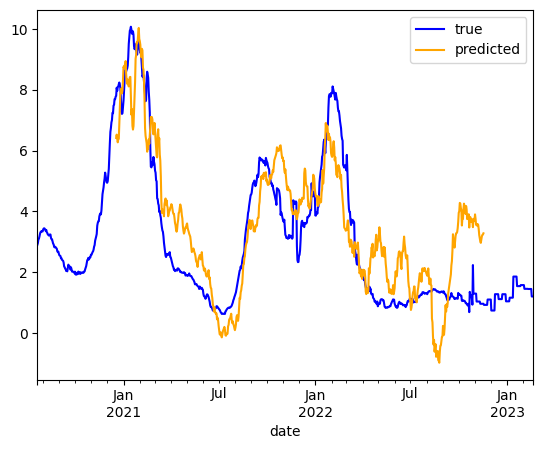

In [208]:
time_range = slice( 0, 1000 )
column = 1

df_pred = df.copy( )
df_pred.iloc[ :, : ] = np.nan
df_pred.iloc[ start : start + length, :3 ] = prediction
df.iloc[ time_range, column ].plot( color = "blue" )
df_pred.iloc[ time_range, column ].plot( color = "orange" )

line = lambda color, label: plt.Line2D([ ], [ ], color = color, label = label )
h = [ line( "blue", "true" ), line( "orange", "predicted" )]

plt.legend( handles = h )
print( df_pred.columns[ column ])